In [32]:
# exploratory analysis

# we want to see if there is a correlation between the music and the EEG data
# baseline 10mins recording with no music & noise cancelling earphones
# 10mins playing the song: Rolling 7s by Dirty Honey...
# (worthnoting, the song is 3:30mins long, so it's played 3 times in a 
# row but we lost some samples due to network issues)
import pandas as pd
import eeg
import datetime
import scipy.fftpack
import numpy as np
import matplotlib.pyplot as plt



In [33]:
files = eeg.extractBundledEEG("./music_data/")
files.prune()
files.mergeTagsWithRegex("[cC]lose","Eyes Closed")
files.mergeCategories(["Working","Eyes Open"],"Eyes Open")
# files.mergeCategories(["Piano","Eyes Open"],"Eyes Open")
# files.mergeCategories(["Chess","Eyes Open"],"Eyes Open")
files.extractByTags("Eyes Open")
#print(files.categories)
print(files.categories)

{'Piano': ['1685140092'], 'Chess': ['1685139735'], '': ['1684960760'], 'Eyes Closed': ['1685033286', '1685139409'], 'Eyes Open': ['1684961211', '1684961614']}


In [34]:
# generate summary of the signalQuality across channels
def get_signal_quality_summary(signalQuality):
    channel_good_percentage = {}

    for col in signalQuality:
        if col in ['CP3_status', 'C3_status', 'F5_status', 'PO3_status', 'PO4_status', 'F6_status', 'C4_status', 'CP4_status']:
            channel_states = signalQuality[col].value_counts()
            
            no_of_okay_samples = 0

            if 'good' in channel_states:
                no_of_okay_samples += channel_states['good']
            if 'great' in channel_states:
                no_of_okay_samples += channel_states['great']

            percentage_good = no_of_okay_samples / len(signalQuality[col])

            col_name_split = col.split('_')

            channel_good_percentage[col_name_split[0]] = percentage_good

    # this helps us know what channels to discard in our analysis
    return channel_good_percentage

In [35]:
def get_rolling_powerByBand(powerByBand, signalQuality, window_size=5):
    # we want to split the recording for a session in to 5sec chunks average
    # see if there's any difference in the average. 

    # we will discard any channels that have less than 70% good samples
    channel_good_percentage = get_signal_quality_summary(signalQuality)

    # we will discard any channels that have less than 70% good samples
    for entry in channel_good_percentage:
        if channel_good_percentage[entry] < 0.7:
            del powerByBand[entry + '_alpha']
            del powerByBand[entry + '_beta']
            del powerByBand[entry + '_delta']
            del powerByBand[entry + '_gamma']
            del powerByBand[entry + '_theta']

    # we will split the recording in to 5sec chunks
    powerByBand_rolling = powerByBand.median() #.rolling(window=window_size).mean()

    # we will discard the first 5sec of the recording
    # powerByBand_rolling = powerByBand_rolling[window_size:]

    return powerByBand_rolling


In [36]:
# load the data
recordings = files.extractByTags("Chess")
recordings = recordings[list(recordings.keys())[0]]
print(datetime.date.fromtimestamp(recordings["Meta"]["startTimestamp"]),recordings["Meta"]["event"]["description"])


powerByBand_eyesclosed = pd.read_json(recordings['powerByBand'])
signalQuality_eyesclosed = pd.read_json(recordings['signalQuality'])

powerByBand_rolling_eyesopen = get_rolling_powerByBand(powerByBand_eyesclosed, signalQuality_eyesclosed)
powerByBand_rolling_eyesopen

2023-05-26 Chess


unixTimestamp    1.685140e+09
CP3_alpha        1.518035e+00
CP3_beta         8.454444e-01
CP3_delta        2.209445e+00
CP3_gamma        1.466405e-01
CP3_theta        2.071048e+00
F5_alpha         1.480190e+00
F5_beta          9.137861e-01
F5_delta         2.327768e+00
F5_gamma         1.636311e-01
F5_theta         2.235780e+00
PO3_alpha        1.719424e+00
PO3_beta         9.606849e-01
PO3_delta        2.524668e+00
PO3_gamma        1.605641e-01
PO3_theta        2.370769e+00
PO4_alpha        2.016675e+00
PO4_beta         1.071559e+00
PO4_delta        2.655382e+00
PO4_gamma        1.775009e-01
PO4_theta        2.585410e+00
CP4_alpha        2.493321e+00
CP4_beta         1.087317e+00
CP4_delta        2.534442e+00
CP4_gamma        1.764604e-01
CP4_theta        2.528069e+00
dtype: float64

In [37]:
# load the data
recordings = files.extractByTags("Eyes Closed")
recordings = recordings[list(recordings.keys())[1]]
print(recordings)
print(datetime.date.fromtimestamp(recordings["Meta"]["startTimestamp"]),recordings["Meta"]["event"]["description"])

powerByBand_music = pd.read_json(recordings['powerByBand'])
signalQuality_music = pd.read_json(recordings['signalQuality'])

powerByBand_rolling_eyesclosed = get_rolling_powerByBand(powerByBand_music, signalQuality_music)


{'focus': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_focus_1685139409.json', 'calm': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_calm_1685139409.json', 'signalQuality': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_signalQuality_1685139409.json', 'event': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_fusion_event_1685139409.json', 'Meta': {'startTimestamp': 1685139409, 'event': {'name': 'Generic Experiment', 'description': 'Eyes Closed', 'value': 'Eyes Closed'}}, 'rawBrainwaves': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_rawBrainwaves_1685139409.json', 'powerByBand': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_powerByBand_1685139409.json'}
2023-05-26 Eyes Closed


76720


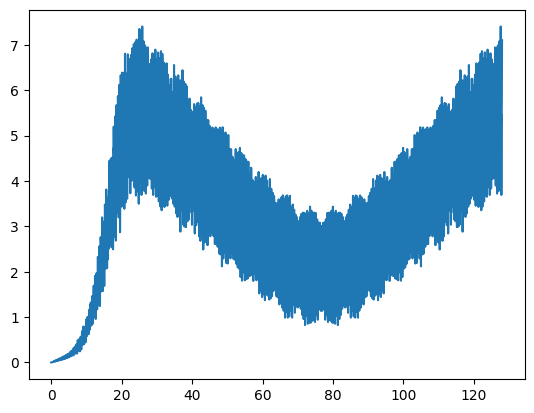

In [38]:
raw = pd.read_json(recordings["rawBrainwaves"])
prev = 0
dif = []
print(len(raw["unixTimestamp"]))

N = 8000
# sample spacing
T = 1.0 / 256.0
yf = scipy.fftpack.fft(list(raw.groupby(["unixTimestamp"]).mean()["F5"]))
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()



In [39]:
# plot manually 

import matplotlib.pyplot as plt
import numpy as np

def plot_powerdiff_by_channel():
    channelIntersection = set(powerByBand_rolling_eyesclosed.index).intersection(set(powerByBand_rolling_eyesopen.index))
    channelIntersection.remove("unixTimestamp")
    channels = set([x[:str(x).index('_')] for x in channelIntersection])
    print(channels, "found with good signal quality in both datasets")
    groups = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    for channel in channels:
        eyesclosed_power = [powerByBand_rolling_eyesclosed[f"{channel}_{band}"] for band in groups]
        eyesopen_power = [powerByBand_rolling_eyesopen[f"{channel}_{band}"] for band in groups]
        # eyesopen_power = [powerByBand_eyes_open[f"{channel}_{band}"] for band in groups]

        barWidth = 0.25

        # Set position of bar on X axis
        br1 = np.arange(len(groups))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        # Y - power
        plt.bar(groups, eyesclosed_power, width = barWidth, label='eyes closed')
        plt.bar(br2, eyesopen_power, width = barWidth, label='eyes open')
        # plt.bar(br3, eyesopen_power, width = barWidth, label='eyes open')

        print(eyesclosed_power)
        print(eyesopen_power)
        # print(eyesopen_power)

        plt.xlabel('Frequency Band')
        plt.ylabel('Power')
        plt.legend()
        plt.title(f'Power for channel {channel}')
        plt.show()
        plt.close()
        

{'CP4', 'PO3', 'CP3', 'F5', 'PO4'} found with good signal quality in both datasets
[3.0090163544948214, 3.0762959201944624, 2.9318894555021897, 1.2228195293033446, 0.19946747520993952]
[2.53444224062756, 2.5280694462381796, 2.4933212386546746, 1.087316778772982, 0.17646035923958253]


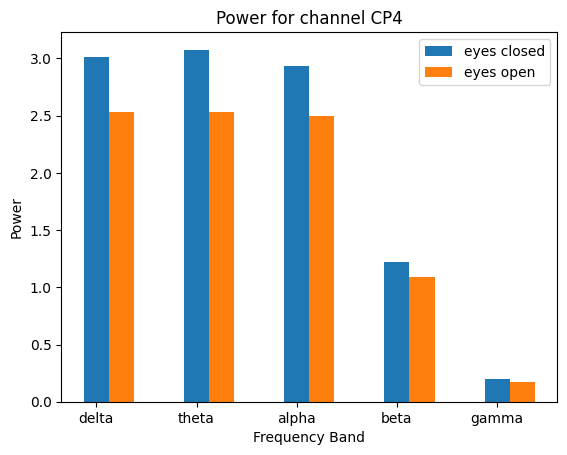

[2.9983910999345325, 2.86391864295671, 2.5507437314604653, 1.141473177808604, 0.18746930453823651]
[2.524668333809371, 2.3707685971980954, 1.7194241365910212, 0.9606848512332691, 0.1605641038162855]


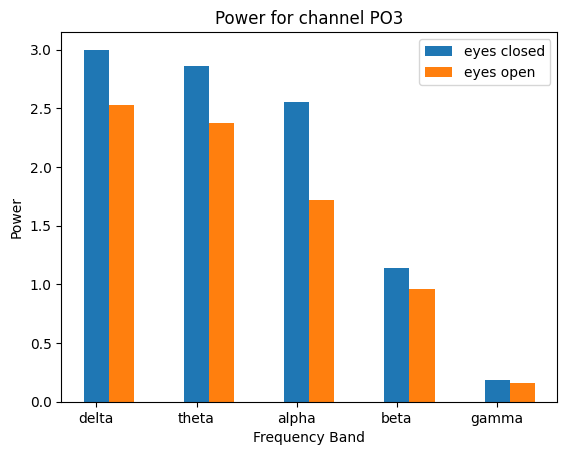

[2.7420429734566047, 2.690975923899374, 2.1538192249167523, 1.030937895111667, 0.17417055118961952]
[2.2094446270813837, 2.0710477032177943, 1.5180349135815892, 0.8454443655192436, 0.1466405302792075]


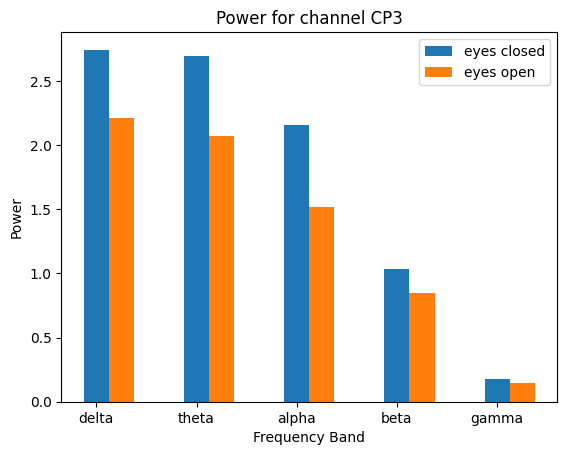

[2.8453907812463974, 2.6466837015653395, 1.704323086331873, 0.9136744751577296, 0.1621116499462405]
[2.3277684421021485, 2.2357799818318087, 1.4801904024456447, 0.9137861251329655, 0.16363108130547552]


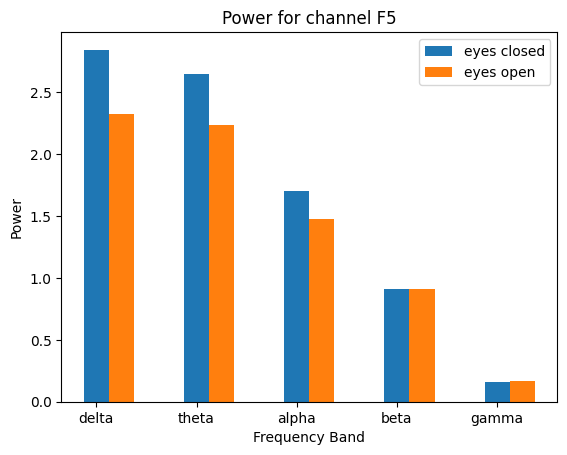

[3.170121123872757, 3.0261855160438724, 3.068228291348494, 1.2511670505432688, 0.20299209128004903]
[2.6553815570974306, 2.585410198748233, 2.016675452572289, 1.071559491349974, 0.17750091792482]


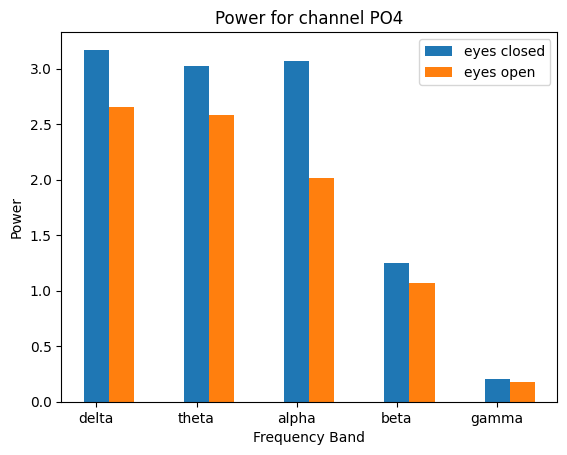

In [40]:
plot_powerdiff_by_channel()

In [41]:
# reduced alpha & increased gamma compared to eyes closed when music was introduced.

In [42]:
# plot power diff by band
def plot_powerdiff_by_band():
    channelIntersection = set(powerByBand_rolling_eyesclosed.index).intersection(set(powerByBand_rolling_eyesopen.index))
    channelIntersection.remove("unixTimestamp")
    channels = set([x[:str(x).index('_')] for x in channelIntersection])
    
    groups = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    for band in groups:
        eyesclosed_power = [powerByBand_rolling_eyesclosed[f"{channel}_{band}"] for channel in channels]
        eyesclosed_music_power = [powerByBand_rolling_music[f"{channel}_{band}"] for channel in channels]

        barWidth = 0.25

        # Set position of bar on X axis
        br1 = np.arange(len(channels))
        br2 = [x + barWidth for x in br1]
        # Y - power
        plt.bar(channels, eyesclosed_power, width = barWidth, label='eyes closed')
        plt.bar(br2, eyesclosed_music_power, width = barWidth, label='music')

        print(eyesclosed_power)
        print(eyesclosed_music_power)

        plt.xlabel('Channel')
        plt.ylabel('Power')
        plt.legend()
        plt.title(f'Power for band {band}')
        plt.show()
        plt.close()

In [43]:
plot_powerdiff_by_band()

NameError: name 'powerByBand_rolling_music' is not defined

In [ ]:
powerByBand_rolling_music

unixTimestamp    1.682194e+09
C3_alpha         1.882589e+00
C3_beta          1.115386e+00
C3_delta         1.466791e+00
C3_gamma         2.476249e-01
C3_theta         1.501871e+00
PO3_alpha        3.176492e+00
PO3_beta         1.518079e+00
PO3_delta        2.322330e+00
PO3_gamma        3.121156e-01
PO3_theta        2.451097e+00
PO4_alpha        3.629393e+00
PO4_beta         1.306642e+00
PO4_delta        1.974752e+00
PO4_gamma        2.580723e-01
PO4_theta        2.104460e+00
CP4_alpha        2.677927e+00
CP4_beta         1.225748e+00
CP4_delta        1.772226e+00
CP4_gamma        2.433631e-01
CP4_theta        1.911529e+00
dtype: float64

In [ ]:
# alpha


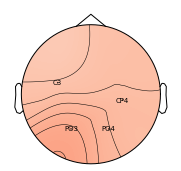

(<matplotlib.image.AxesImage at 0x17fe58130>,
 <matplotlib.contour.QuadContourSet at 0x17fe58490>)

In [ ]:
# plot top map

import numpy as np
import matplotlib.pyplot as plt
import mne

power_dict = {
    'C3': powerByBand_rolling_music['C3_beta'],
    'PO3': powerByBand_rolling_music['PO3_beta'],
    'PO4': powerByBand_rolling_music['PO4_beta'],
    'CP4': powerByBand_rolling_music['CP4_beta'],
}

# Define the channel names for the 10-10 EEG system
ch_names = list(power_dict.keys())
powers = np.array(list(power_dict.values()))

# Create an info object for the 10-10 EEG system
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types='eeg', verbose=True)
# Create the montage
montage = mne.channels.make_standard_montage('standard_1005')
info.set_montage(montage)

# Plot the topomap
mne.viz.plot_topomap(powers, info, ch_type='eeg', vlim=(0,5), names=power_dict.keys(), size=3, show=True)